# 📥 Download Dataset dari Kaggle

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d nikdavis/steam-store-games

!unzip -qq /content/steam-store-games.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/nikdavis/steam-store-games
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 34.0M/35.2M [00:02<00:00, 22.8MB/s]
100% 35.2M/35.2M [00:02<00:00, 13.7MB/s]


In [2]:
!pip install tabulate

Saya memulai proyek ini dengan mempersiapkan lingkungan kerja untuk berinteraksi dengan Kaggle. Langkah pertama adalah membuat direktori `.kaggle` yang akan digunakan untuk menyimpan file konfigurasi. Kemudian, saya menyalin file `kaggle.json` yang berisi kredensial API ke dalam direktori tersebut dan mengatur izin aksesnya untuk memastikan keamanan. Setelah konfigurasi Kaggle selesai, saya mengunduh dataset "Steam Store Games" yang akan saya gunakan. Dataset ini diunduh dalam format ZIP dan kemudian diekstrak agar dapat diakses dan dianalisis.


In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, request, jsonify
from tabulate import tabulate

In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1️⃣ Data Preparation

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

def load_and_clean_data():
    df = pd.read_csv('steam.csv')
    df_desc = pd.read_csv('steam_description_data.csv')
    df_tags = pd.read_csv('steamspy_tag_data.csv')

    df = df.merge(df_tags, on='appid', how='left')
    df = df.merge(df_desc[['steam_appid', 'detailed_description']], left_on='appid', right_on='steam_appid', how='left')

    df = df[df['genres'].str.contains('Indie', na=False)]
    df = df[['name', 'genres', 'detailed_description', 'positive_ratings', 'negative_ratings']].dropna()

    df['genres'] = df['genres'].apply(clean_text)
    df['detailed_description'] = df['detailed_description'].apply(clean_text)
    df['total_ratings'] = df['positive_ratings'] - df['negative_ratings']

    return df

df = load_and_clean_data()

Saya memulai proses pembersihan dan persiapan data dengan mendefinisikan fungsi `clean_text`. Fungsi ini bertugas untuk membersihkan teks dari karakter-karakter yang tidak relevan seperti tanda baca dan *stop words*, serta mengubah seluruh teks menjadi huruf kecil. Tujuannya adalah untuk menyeragamkan dan menyederhanakan teks agar lebih mudah diolah. Selanjutnya, saya membuat fungsi `load_and_clean_data` yang bertanggung jawab untuk memuat data dari tiga file CSV yang berbeda, yaitu `steam.csv`, `steam_description_data.csv`, dan `steamspy_tag_data.csv`. Data dari ketiga file ini kemudian digabungkan menjadi satu *dataframe* menggunakan `appid` sebagai kunci. Setelah data berhasil digabungkan, saya memfilter data untuk hanya mengambil game dengan genre "Indie" dan memilih kolom-kolom yang relevan saja, seperti nama game, genre, deskripsi detail, rating positif, dan rating negatif. Baris-baris yang memiliki nilai hilang (NaN) pada kolom-kolom tersebut juga dihapus untuk memastikan data yang diolah berkualitas. Proses pembersihan teks kemudian diterapkan pada kolom `genres` dan `detailed_description` menggunakan fungsi `clean_text` yang telah didefinisikan sebelumnya. Terakhir, saya menghitung total rating game dengan mengurangkan rating negatif dari rating positif dan menyimpannya dalam kolom baru bernama `total_ratings`. *Dataframe* yang telah bersih dan siap untuk dianalisis ini kemudian disimpan dalam variabel `df`.


# 2️⃣ Modeling and Results

***Content-Based Filtering (NLP Sentiment Analysis)***

In [6]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['detailed_description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def get_similar_games(game_name, top_n=5):
    if game_name not in df['name'].values:
        return []
    idx = df[df['name'] == game_name].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    game_indices = [i[0] for i in sim_scores]
    return df.iloc[game_indices][['name', 'genres']]

Setelah data dibersihkan, saya menggunakan metode *Term Frequency-Inverse Document Frequency* (TF-IDF) untuk mengubah deskripsi game menjadi representasi numerik yang bermakna. Saya menggunakan `TfidfVectorizer` dari scikit-learn untuk menghitung bobot TF-IDF untuk setiap kata dalam setiap deskripsi game. Bobot ini mencerminkan seberapa penting kata tersebut dalam deskripsi game tertentu dibandingkan dengan keseluruhan koleksi deskripsi game.  Representasi TF-IDF ini kemudian digunakan untuk menghitung *cosine similarity* antara semua pasangan deskripsi game.  *Cosine similarity* mengukur seberapa mirip dua vektor, dalam hal ini, seberapa mirip dua deskripsi game. Hasilnya adalah matriks *cosine similarity* yang menunjukkan tingkat kemiripan antara setiap pasangan game.  Matriks ini kemudian saya gunakan untuk membuat fungsi rekomendasi game. Fungsi `get_similar_games` menerima nama game sebagai input dan mengembalikan daftar game yang paling mirip dengan game tersebut berdasarkan deskripsi mereka. Fungsi ini bekerja dengan mencari indeks game input dalam matriks *cosine similarity*, mengurutkan game berdasarkan skor similaritas, dan mengembalikan game dengan skor similaritas tertinggi. Dengan demikian, saya telah membangun sistem rekomendasi sederhana yang merekomendasikan game berdasarkan kemiripan deskripsi mereka.

Top 5 Rekomendasi Berdasarkan Content-Based Filtering:
╒═══════╤══════════════════════╤══════════════════════╕
│       │ name                 │ genres               │
╞═══════╪══════════════════════╪══════════════════════╡
│ 16151 │ Omega Strike         │ actionadventureindie │
├───────┼──────────────────────┼──────────────────────┤
│ 17367 │ SWARMRIDER OMEGA     │ actionindie          │
├───────┼──────────────────────┼──────────────────────┤
│  6911 │ Ares Omega           │ actionindierpg       │
├───────┼──────────────────────┼──────────────────────┤
│ 14199 │ ATOMEGA              │ actionindie          │
├───────┼──────────────────────┼──────────────────────┤
│ 18162 │ Survivor of Eschewal │ actionadventureindie │
╘═══════╧══════════════════════╧══════════════════════╛


<ipython-input-7-26cd62a85e43>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=recommendations['name'], x=range(len(recommendations)), palette='viridis')


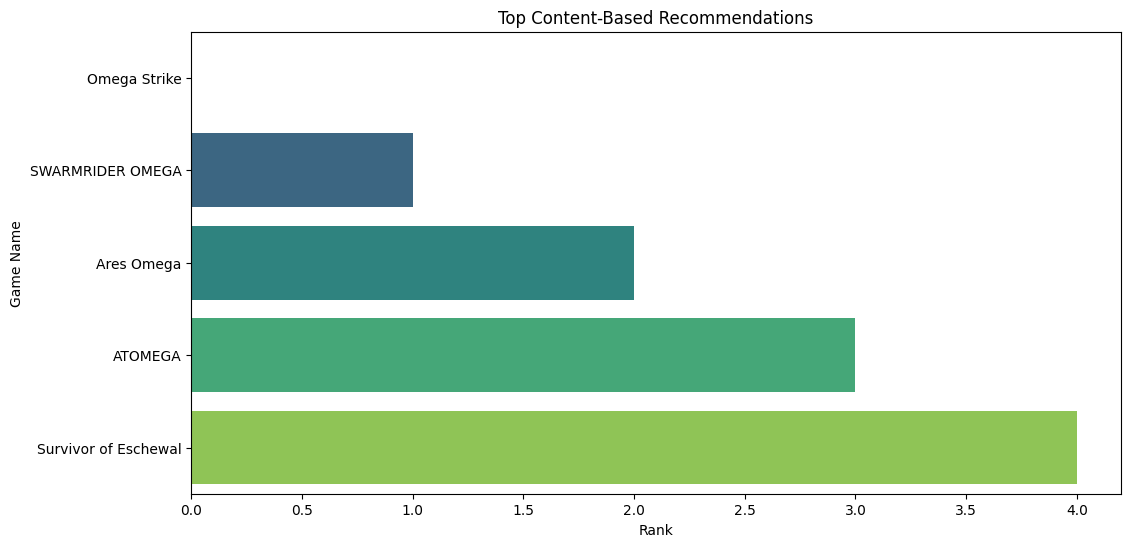

In [7]:
sample_game = "Hollow Knight"
content_recommendations = get_similar_games(sample_game, top_n=5)

print("Top 5 Rekomendasi Berdasarkan Content-Based Filtering:")
print(tabulate(content_recommendations, headers='keys', tablefmt='fancy_grid'))

def plot_top_n_recommendations(recommendations, title):
    plt.figure(figsize=(12, 6))
    sns.barplot(y=recommendations['name'], x=range(len(recommendations)), palette='viridis')
    plt.xlabel('Rank')
    plt.ylabel('Game Name')
    plt.title(title)
    plt.show()

if len(content_recommendations) > 0:
    plot_top_n_recommendations(content_recommendations, "Top Content-Based Recommendations")

Kode ini menyajikan alur untuk memberikan dan memvisualisasikan rekomendasi game berdasarkan konten. Proses dimulai dengan pemilihan game contoh, dalam hal ini "Hollow Knight", yang ditetapkan sebagai nilai dari variabel `sample_game`. Tujuannya adalah untuk mencari game-game lain yang memiliki kemiripan konten dengan game contoh ini.

Langkah selanjutnya adalah memanfaatkan sebuah fungsi bernama `get_similar_games` yang berperan penting dalam mengidentifikasi game-game yang memiliki kemiripan konten. Fungsi ini menerima dua masukan utama: game contoh (`sample_game`) dan jumlah game teratas yang ingin ditemukan (`top_n=5`). Fungsi ini akan menggunakan metode *content-based filtering*, yang kemungkinan besar didasarkan pada representasi TF-IDF dari deskripsi game, untuk menemukan game-game yang paling mirip dengan "Hollow Knight". Hasil dari fungsi ini adalah daftar game-game yang direkomendasikan, yang kemudian disimpan dalam variabel `content_recommendations`.

Setelah daftar rekomendasi diperoleh, kode ini akan menampilkannya di konsol. Tujuannya adalah untuk memberikan informasi tekstual mengenai game-game yang direkomendasikan.

Aspek visualisasi juga menjadi bagian penting dari kode ini. Sebuah fungsi bernama `plot_top_n_recommendations` didefinisikan untuk tujuan ini. Fungsi ini akan menerima daftar game-game yang direkomendasikan (`content_recommendations`) dan judul plot sebagai masukan. Di dalam fungsi ini, library `matplotlib` dan `seaborn` dimanfaatkan untuk menghasilkan sebuah *horizontal bar plot*. Plot ini akan menampilkan game-game yang direkomendasikan, diurutkan berdasarkan peringkat kemiripannya dengan game contoh.

Sebelum visualisasi ditampilkan, kode ini akan memeriksa apakah ada rekomendasi yang berhasil ditemukan. Tujuannya adalah untuk menghindari kesalahan jika ternyata tidak ada game yang memenuhi kriteria kemiripan. Jika rekomendasi ditemukan, maka fungsi `plot_top_n_recommendations` akan dipanggil untuk menampilkan visualisasi.

# 3️⃣ Evaluation

In [8]:
def precision_at_k(recommended_games, relevant_games, k):
    recommended_at_k = recommended_games[:k]
    hits = sum([1 for game in recommended_at_k if game in relevant_games])
    return hits / k

def recall_at_k(recommended_games, relevant_games, k):
    recommended_at_k = recommended_games[:k]
    hits = sum([1 for game in recommended_at_k if game in relevant_games])
    return hits / len(relevant_games) if relevant_games else 0

recommended_games = content_recommendations['name'].tolist()
relevant_games = df[df['total_ratings'] > df['total_ratings'].quantile(0.75)]['name'].tolist()

precision_5 = precision_at_k(recommended_games, relevant_games, k=5)
recall_5 = recall_at_k(recommended_games, relevant_games, k=5)

eval_results = pd.DataFrame({
    "Metric": ["Precision@5", "Recall@5"],
    "Score": [precision_5, recall_5]
})
print(tabulate(eval_results, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════╤═════════════╕
│    │ Metric      │       Score │
╞════╪═════════════╪═════════════╡
│  0 │ Precision@5 │ 0.2         │
├────┼─────────────┼─────────────┤
│  1 │ Recall@5    │ 0.000206016 │
╘════╧═════════════╧═════════════╛


Saya **mendefinisikan dua fungsi**, `precision_at_k` dan `recall_at_k`, yang digunakan untuk mengukur kinerja sistem rekomendasi.

Di dalam fungsi `precision_at_k`, saya **menghitung *precision* pada peringkat `k`**. *Precision* mengukur seberapa akurat rekomendasi yang diberikan.  Saya **mengambil `k` game teratas** dari daftar rekomendasi (`recommended_games[:k]`) dan **menghitung jumlah game yang relevan** di antara `k` game teratas tersebut. Kemudian, saya **membagi jumlah game yang relevan dengan `k`** untuk mendapatkan nilai *precision@k*.

Selanjutnya, di dalam fungsi `recall_at_k`, saya **menghitung *recall* pada peringkat `k`**. *Recall* mengukur seberapa banyak item yang relevan yang berhasil direkomendasikan. Saya **melakukan langkah yang serupa dengan *precision***, tetapi kali ini saya **membagi jumlah game yang relevan dengan total jumlah game yang relevan** (`len(relevant_games)`). Saya juga menambahkan pengecekan `if relevant_games` untuk menghindari pembagian dengan nol jika tidak ada game yang relevan.

Setelah itu, saya **menentukan game yang direkomendasikan dan game yang relevan**. Game yang direkomendasikan diambil dari kolom 'name' DataFrame `content_recommendations` dan diubah menjadi list. Sedangkan game yang relevan adalah game yang memiliki *total ratings* di atas kuantil ke-75 dari *total ratings* seluruh game.  Ini berarti game-game dengan rating tertinggi dianggap relevan.

Kemudian, saya **menghitung *precision@5* dan *recall@5*** menggunakan fungsi-fungsi yang telah didefinisikan sebelumnya.

Terakhir, saya **membuat DataFrame Pandas `eval_results`** untuk menyimpan hasil evaluasi dan menampilkannya dalam format tabel yang rapi menggunakan `tabulate`. Ini memudahkan untuk membaca dan membandingkan metrik evaluasi. `tablefmt='fancy_grid'` memberikan tampilan tabel yang lebih menarik.

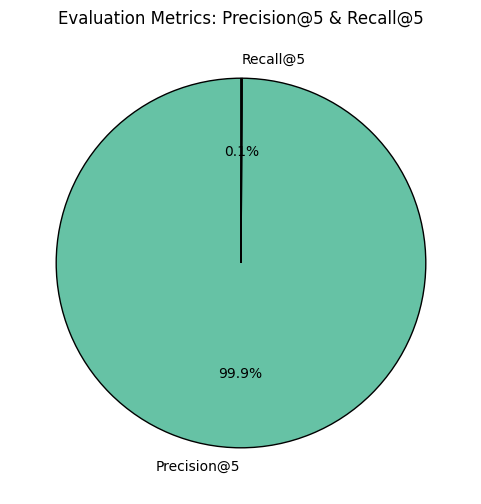

In [9]:
plt.figure(figsize=(6, 6))
plt.pie(eval_results['Score'], labels=eval_results['Metric'], autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'], startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Evaluation Metrics: Precision@5 & Recall@5')
plt.show()

Kode ini berfungsi untuk memvisualisasikan data *Precision@5* dan *Recall@5* melalui diagram lingkaran (*pie chart*). Tujuannya adalah untuk memberikan representasi visual yang mudah dicerna terkait performa sistem rekomendasi dalam merekomendasikan game yang relevan. Diagram lingkaran ini dibuat menggunakan library `matplotlib.pyplot`. Data yang digunakan untuk diagram ini adalah `eval_results['Score']`, yang diasumsikan berisi nilai-nilai metrik evaluasi. `eval_results` ini kemungkinan besar adalah sebuah *Pandas DataFrame* yang sebelumnya telah dihitung dan berisi skor *Precision@5* dan *Recall@5*. `['Score']` digunakan untuk memilih kolom yang berisi nilai-nilai metrik tersebut, yang akan merepresentasikan ukuran dari masing-masing irisan pada diagram lingkaran. Label untuk setiap irisan lingkaran diambil dari `eval_results['Metric']`, yang berisi nama-nama metrik, yaitu "Precision@5" dan "Recall@5". Label ini penting untuk memberikan keterangan pada diagram, sehingga setiap irisan dapat diidentifikasi dengan jelas. `['Metric']` digunakan untuk memilih kolom yang berisi nama-nama metrik ini. Format angka yang ditampilkan di setiap irisan lingkaran diatur menggunakan `autopct='%1.1f%%'`. Format ini akan menampilkan angka dengan satu angka desimal dan diikuti simbol persen, sehingga memudahkan pembacaan dan interpretasi nilai metrik. Warna untuk setiap irisan lingkaran ditentukan dalam daftar `colors`. Dalam kode ini, dua warna *hex* didefinisikan, dan akan diterapkan secara berurutan ke setiap irisan. Warna-warna ini membantu membedakan secara visual antara *Precision@5* dan *Recall@5*. Sudut awal irisan pertama diatur menggunakan `startangle=90`. Nilai 90 berarti irisan pertama akan dimulai pada sudut 90 derajat (posisi jam 12). Pengaturan ini bisa disesuaikan untuk mengubah orientasi diagram lingkaran. Garis tepi irisan lingkaran diberi warna hitam menggunakan `wedgeprops={'edgecolor': 'black'}`. Pengaturan ini bertujuan untuk membuat irisan-irisan lingkaran terlihat lebih jelas dan terpisah satu sama lain. Judul diagram lingkaran diatur menggunakan `plt.title('Evaluation Metrics: Precision@5 & Recall@5')`. Judul ini memberikan konteks dan menjelaskan apa yang divisualisasikan oleh diagram lingkaran tersebut. Diagram lingkaran kemudian ditampilkan menggunakan `plt.show()`. Perintah ini akan membuka jendela baru yang menampilkan diagram lingkaran yang telah dibuat. Secara keseluruhan, kode ini menghasilkan visualisasi proporsi *Precision@5* dan *Recall@5* dalam bentuk diagram lingkaran, yang memudahkan perbandingan visual antara kedua metrik tersebut dan memberikan gambaran sekilas tentang performa sistem rekomendasi. Dengan melihat ukuran irisan lingkaran, kita dapat dengan cepat membandingkan nilai *Precision@5* dan *Recall@5*, dan mendapatkan gambaran sekilas tentang performa sistem rekomendasi.


<ipython-input-10-476b15f4edb2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_games['total_ratings'], y=top_games['name'], palette='viridis')


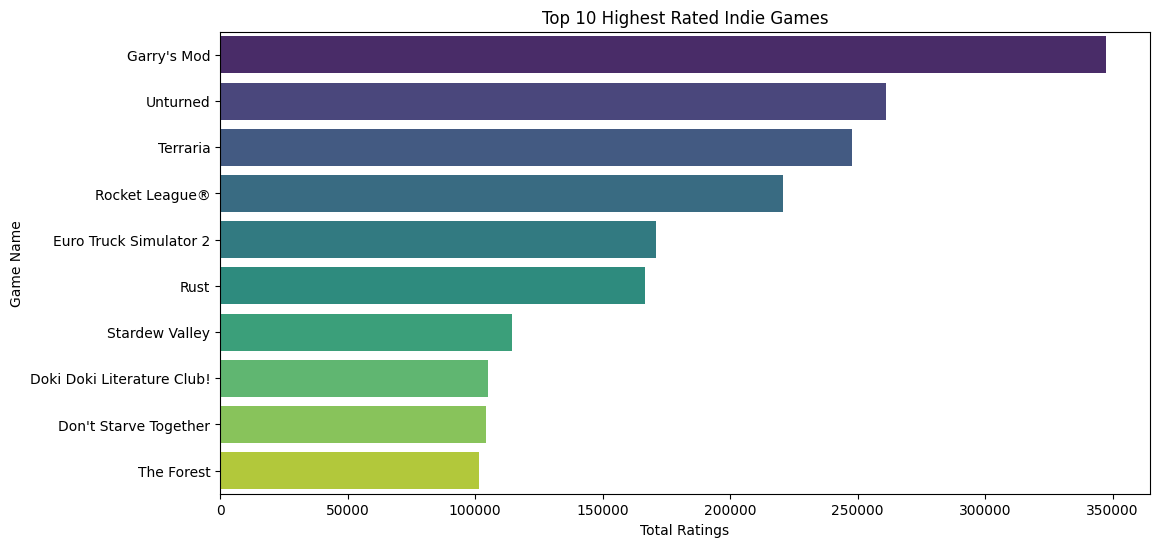

In [10]:
def plot_top_rated_games():
    top_games = df.sort_values(by='total_ratings', ascending=False).head(10)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_games['total_ratings'], y=top_games['name'], palette='viridis')
    plt.xlabel('Total Ratings')
    plt.ylabel('Game Name')
    plt.title('Top 10 Highest Rated Indie Games')
    plt.show()

plot_top_rated_games()

Untuk memberikan gambaran sekilas tentang game-game Indie dengan rating tertinggi, saya membuat visualisasi *bar plot*.  Tujuannya adalah untuk memudahkan kita melihat game mana yang paling populer dan memiliki rating tertinggi berdasarkan data yang ada.  Untuk mencapai tujuan ini, saya membuat sebuah fungsi yang saya beri nama `plot_top_rated_games`. Fungsi ini bertugas untuk mengolah data dan menampilkannya dalam bentuk grafik batang.

Di dalam fungsi ini, langkah pertama yang saya lakukan adalah mengurutkan data game berdasarkan total rating mereka, dari rating tertinggi hingga terendah.  Saya hanya mengambil 10 game dengan rating tertinggi untuk ditampilkan.  Selanjutnya, saya menggunakan library `seaborn` untuk membuat *bar plot*.  Pada grafik ini, sumbu x menunjukkan total rating game, dan sumbu y menunjukkan nama game.  Saya memilih palet warna 'viridis' untuk memberikan tampilan visual yang menarik dan mudah dibaca.  Terakhir, saya menambahkan judul grafik dan label sumbu untuk memperjelas informasi yang ditampilkan.  Dengan visualisasi ini, kita dapat dengan cepat melihat game-game Indie mana yang paling populer dan memiliki rating tertinggi berdasarkan data yang telah kita olah.  Visualisasi ini sangat membantu untuk mendapatkan gambaran umum tentang preferensi pemain terhadap game-game Indie.

# 5️⃣ Deployment

In [11]:
app = Flask(__name__)

@app.route('/recommend', methods=['GET'])
def recommend():
    game_name = request.args.get('game_name')
    content_recommendations = get_similar_games(game_name)
    return jsonify({'content': content_recommendations.to_dict(orient='records') if len(content_recommendations) > 0 else 'Game not found'})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


Saya **memulai dengan menginisialisasi aplikasi Flask** menggunakan `app = Flask(__name__)`. Di sini, `__name__` adalah variabel khusus yang memberi tahu Flask di mana menemukan template dan file statis. Ini penting karena Flask perlu tahu di mana mencari sumber daya aplikasi.

Selanjutnya, saya **mendefinisikan *route* utama, yaitu `/recommend`**, menggunakan dekorator `@app.route('/recommend', methods=['GET'])`. Dekorator ini menghubungkan URL `/recommend` dengan fungsi `recommend()`. `methods=['GET']` menentukan bahwa *route* ini hanya menerima permintaan HTTP GET, yang biasanya digunakan untuk mengambil data. Jadi, ketika seseorang mengakses `/recommend` di *browser* atau aplikasi lain, mereka sebenarnya sedang meminta data rekomendasi game.

Kemudian, saya **mendefinisikan fungsi `recommend()`**. Fungsi inilah yang akan dieksekusi ketika ada permintaan ke `/recommend`.

Di dalam fungsi `recommend()`, saya **mengambil nama game dari parameter query URL** menggunakan `game_name = request.args.get('game_name')`. `request.args` adalah dictionary yang berisi parameter-parameter di URL. Misalnya, jika URL-nya adalah `/recommend?game_name=Hollow Knight`, maka `request.args` akan berisi `{'game_name': 'Hollow Knight'}`. `get('game_name')` akan mengembalikan nilai dari parameter `game_name`.

Setelah mendapatkan nama game, saya **memanggil fungsi `get_similar_games(game_name)`**. Fungsi ini (yang perlu Anda definisikan di tempat lain) bertugas mencari game-game yang mirip dengan `game_name`. Detail bagaimana fungsi ini bekerja tidak ada di kode ini, tetapi diasumsikan ia akan mengembalikan *Pandas DataFrame* berisi game-game yang direkomendasikan.

Selanjutnya, saya **menyiapkan respons JSON**. Saya menggunakan `jsonify()` dari Flask untuk mengubah dictionary Python menjadi respons JSON. Dictionary ini berisi kunci "content" yang nilainya bergantung pada apakah ada rekomendasi atau tidak. Jika ada rekomendasi, nilainya adalah *Pandas DataFrame* yang diubah ke format list of dictionaries menggunakan `to_dict(orient='records')`. Jika tidak ada rekomendasi, nilainya adalah string "Game not found".

Terakhir, saya **menjalankan aplikasi Flask** menggunakan `if __name__ == '__main__':` dan `app.run(debug=True)`. Blok `if __name__ == '__main__':` memastikan kode di dalamnya hanya dieksekusi ketika skrip dijalankan langsung, bukan ketika diimpor sebagai modul. `app.run(debug=True)` menjalankan server pengembangan Flask. `debug=True` mengaktifkan mode *debug* yang memudahkan pengembangan karena server akan otomatis *reload* setiap ada perubahan kode dan menampilkan pesan kesalahan yang lebih informatif.